In [1]:
from subprocess import Popen, PIPE

import numpy as np
import pandas as pd
import xarray as xr

from glob import glob
from os.path import isfile
from datetime import datetime, timedelta

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
obdir = '/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/observations/'

#### Use the automated data as a baseline/sanity check
Data is obtained from mesowest API - May use the timeseries or precipitation service<br>
https://developers.synopticdata.com/mesonet/v2/stations/timeseries/<br>
https://developers.synopticdata.com/mesonet/v2/stations/precipitation/<br>
To save long records, will need to access as csv format not json


In [3]:
site_auto = 'CLN_AUTO'
f_auto = glob(obdir + '%s*.csv'%site_auto)[0]

# Remove the units row (SI - C, mm)
data_auto = pd.read_csv(f_auto, low_memory=False)[1:]
data_auto = data_auto.drop(columns='Station_ID')

renames_auto = {'Date_Time':'time', 
                'precip_accum_one_hour_set_1':'swe_auto_mm',
                'snow_interval_set_1':'snow_auto_mm', 
                'snow_depth_set_1':'depth_auto_mm', 
                'air_temp_set_1':'tsfc_c'}

data_auto = data_auto.rename(columns=renames_auto)

# Fix the datatypes
data_auto['time'] = data_auto['time'].astype('datetime64[ns]')
data_auto = data_auto.set_index('time')

data_auto = data_auto.astype({k:np.float32 for k in data_auto.keys()})

# Noticed later in plotting that the data is labeled mm but acutally in cm, fix here
data_auto['snow_auto_mm'] /= 10

data_auto[:10]

,tsfc_c,snow_auto_mm,depth_auto_mm,swe_auto_mm
time,,,,
1997-01-01 00:00:00,1.11,NaN,2311.399902,NaN
1997-01-01 01:00:00,0.56,NaN,2311.399902,NaN
1997-01-01 02:00:00,0.56,NaN,2311.399902,NaN
1997-01-01 03:00:00,2.22,NaN,2311.399902,NaN
1997-01-01 04:00:00,3.33,NaN,2311.399902,NaN
1997-01-01 05:00:00,3.89,NaN,2311.399902,NaN
1997-01-01 06:00:00,3.89,NaN,2311.399902,NaN
1997-01-01 07:00:00,2.78,NaN,2286.000000,NaN
1997-01-01 08:00:00,2.22,NaN,2286.000000,NaN


#### Isolate precipitating (snow) periods

In [4]:
# Since the ERA 3h may be used, reduce hourly to 3h data
kwargs = {'rule':'3H', 'base':0, 
          'label':'right', 'closed':'right'}

data_auto3h = pd.DataFrame([
    data_auto['tsfc_c'].resample(**kwargs).max(),
    data_auto['swe_auto_mm'].resample(**kwargs).sum(),
    data_auto['snow_auto_mm'].resample(**kwargs).sum()]).T

data_auto3h[:10]

<ipython-input-4-788b02156f63>:6: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  data_auto['tsfc_c'].resample(**kwargs).max(),
<ipython-input-4-788b02156f63>:7: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  data_auto['swe_auto_mm'].resample(**kwargs).sum(),
<ipython-input-4-788b02156f63>:8: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  data_auto['snow_auto_mm'].resample(**kwargs).sum()]).T


,tsfc_c,swe_auto_mm,snow_auto_mm
time,,,
1997-01-01 00:00:00,1.11,0.0,0.0
1997-01-01 03:00:00,2.22,0.0,0.0
1997-01-01 06:00:00,3.89,0.0,0.0
1997-01-01 09:00:00,2.78,0.0,0.0
1997-01-01 12:00:00,2.22,0.0,0.0
1997-01-01 15:00:00,1.67,0.0,0.0
1997-01-01 18:00:00,2.78,0.0,0.0
1997-01-01 21:00:00,4.44,0.0,0.0
1997-01-02 00:00:00,5.56,0.0,0.0


In [5]:
# Write these out to a file later
precip_periods = data_auto[(
    (data_auto['snow_auto_mm'] > 0.) & 
    (data_auto['swe_auto_mm'] > 0.) &
    (data_auto['tsfc_c'] <= 6.))].index

precip_periods3h = data_auto3h[(
    (data_auto3h['snow_auto_mm'] > 0.) & 
    (data_auto3h['swe_auto_mm'] > 0.) &
    (data_auto3h['tsfc_c'] <= 6.))].index

precip_periods[:5], precip_periods3h[:5]

(DatetimeIndex(['2004-10-24 17:00:00', '2004-10-24 21:00:00',
                '2004-10-24 22:00:00', '2004-10-25 06:00:00',
                '2004-10-25 07:00:00'],
               dtype='datetime64[ns]', name='time', freq=None),
 DatetimeIndex(['2004-10-24 18:00:00', '2004-10-24 21:00:00',
                '2004-10-25 00:00:00', '2004-10-25 06:00:00',
                '2004-10-25 09:00:00'],
               dtype='datetime64[ns]', name='time', freq=None))

In [6]:
site = 'CLN'
f = glob(obdir + '%s*.csv'%site)[0]

data_raw = pd.read_csv(f, low_memory=False)
data_raw = data_raw.set_index(['DATE'])

data_time = np.array([[datetime.strptime(d+t, '%m/%d/%y %H%M') for t in [' 0400', ' 1600']] for d in data_raw.index]).flatten()
data_raw = np.array([[(data_raw.loc[d]['%sWATER'%t], data_raw.loc[d]['%sSNOW'%t]) for t in ['0400', '1600']] for d in data_raw.index])
data_raw = data_raw.reshape(-1, 2)

data = pd.DataFrame([data_time, data_raw[:, 0], data_raw[:, 1]]).T
data = data.rename(columns={0:'time', 1:'swe_in', 2:'snow_in'}).set_index('time')

# Convert in to mm
data['swe_mm'] = data['swe_in'] * 25.4
data['snow_mm'] = data['snow_in'] * 25.4
data['slr'] = data['snow_mm']/data['swe_mm']
data = data.drop(columns=['swe_in', 'snow_in'])

data = data.fillna(np.nan)
for k in data.keys():
    try:
        data[k] = data[k].astype(np.float32)
    except:
        pass

data[:10]

,swe_mm,snow_mm,slr
time,,,
1999-11-01 04:00:00,0.0,0.0,NaN
1999-11-01 16:00:00,0.0,0.0,NaN
1999-11-02 04:00:00,0.0,0.0,NaN
1999-11-02 16:00:00,0.0,0.0,NaN
1999-11-03 04:00:00,0.0,0.0,NaN
1999-11-03 16:00:00,0.0,0.0,NaN
1999-11-04 04:00:00,0.0,0.0,NaN
1999-11-04 16:00:00,0.0,0.0,NaN
1999-11-05 04:00:00,0.0,0.0,NaN


#### Resample the hourlies to match the 12h

In [7]:
data_auto_tmax12 = data_auto['tsfc_c'].resample('12H', closed='right', label='right', base=4).max().rename('tsfc_max_c')
data_auto_swe12 = data_auto['swe_auto_mm'].resample('12H', closed='right', label='right', base=4).sum()
data_auto_snow12 = data_auto['snow_auto_mm'].resample('12H', closed='right', label='right', base=4).sum()
data_auto_12 = pd.DataFrame([data_auto_swe12, data_auto_snow12, data_auto_tmax12]).T
data_auto_12[:10]

<ipython-input-7-36c2aa017548>:1: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  data_auto_tmax12 = data_auto['tsfc_c'].resample('12H', closed='right', label='right', base=4).max().rename('tsfc_max_c')
<ipython-input-7-36c2aa017548>:2: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  data_auto_swe12 = data_auto['swe_auto_mm'].resample('12H', closed='right', label='right', base=4).sum()
<ipython-input-7-36c2aa017548>:3: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  data

,swe_auto_mm,snow_auto_mm,tsfc_max_c
time,,,
1997-01-01 04:00:00,0.0,0.0,3.33
1997-01-01 16:00:00,0.0,0.0,3.89
1997-01-02 04:00:00,0.0,0.0,5.56
1997-01-02 16:00:00,0.0,0.0,6.11
1997-01-03 04:00:00,0.0,0.0,4.44
1997-01-03 16:00:00,0.0,0.0,-1.67
1997-01-04 04:00:00,0.0,0.0,-3.89
1997-01-04 16:00:00,0.0,0.0,-12.78
1997-01-05 04:00:00,0.0,0.0,-12.22


In [8]:
data_all = data.merge(data_auto_12, on='time')
data_all[:10]

,swe_mm,snow_mm,slr,swe_auto_mm,snow_auto_mm,tsfc_max_c
time,,,,,,
1999-11-01 04:00:00,0.0,0.0,NaN,0.0,0.0,9.44
1999-11-01 16:00:00,0.0,0.0,NaN,0.0,0.0,2.22
1999-11-02 04:00:00,0.0,0.0,NaN,0.0,0.0,7.22
1999-11-02 16:00:00,0.0,0.0,NaN,0.0,0.0,1.11
1999-11-03 04:00:00,0.0,0.0,NaN,0.0,0.0,7.22
1999-11-03 16:00:00,0.0,0.0,NaN,0.0,0.0,2.22
1999-11-04 04:00:00,0.0,0.0,NaN,0.0,0.0,7.78
1999-11-04 16:00:00,0.0,0.0,NaN,0.0,0.0,4.44
1999-11-05 04:00:00,0.0,0.0,NaN,0.0,0.0,8.89


#### Ensure that the data isn't mislabeled by plotting/visualizing segments
These should be correct, but check that the beginning of period isn't labeled instead of end, etc.<br>
A time-shift correction can be applied if needed. Keep in mind the automated data will likely <br>
underreport vs the manual observations so consider the timing more than event size

No handles with labels found to put in legend.
No handles with labels found to put in legend.


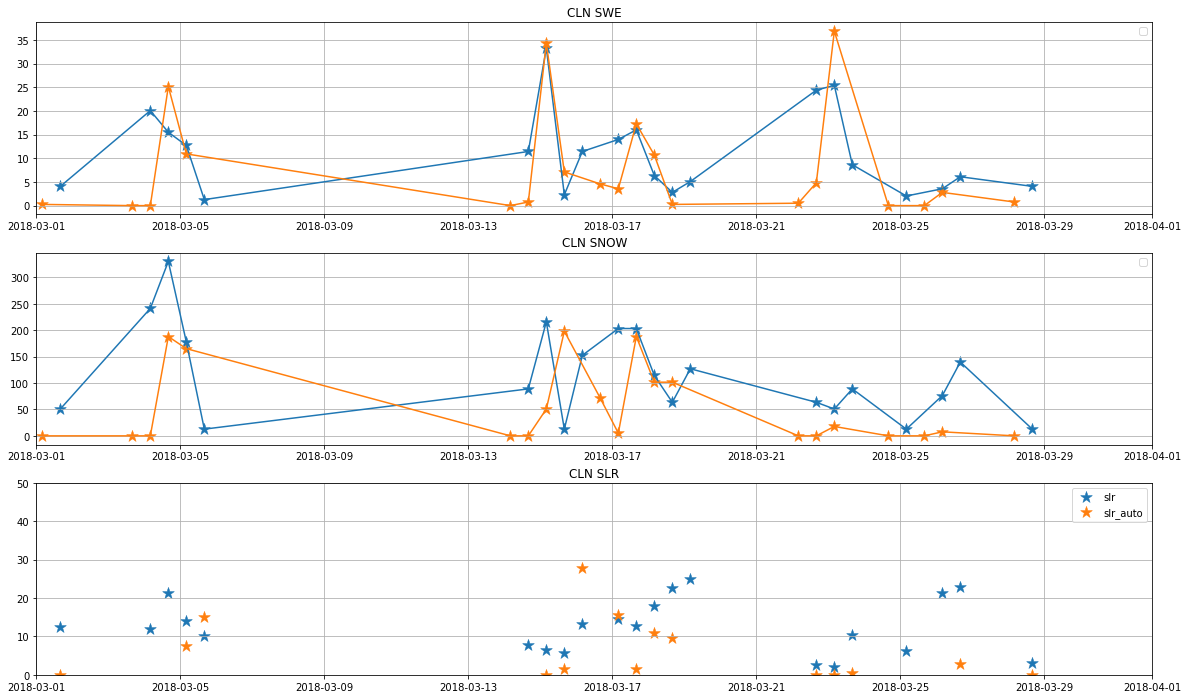

In [9]:
# I think the Alta dataset is labeled with the period START not END... 
# 12 hour time shift seems to fix the issue with the data
time_shift = 12

fig, axs = plt.subplots(3, 1, figsize=(20, 12), facecolor='w')
d0 = datetime(2018, 3, 1, 0, 0)
d1 = datetime(2018, 4, 1, 0, 0)

mask = ((data_all.index > d0) & (data_all.index <= d1) & 
        (data_all['swe_mm'] > 0.) & (data_all['snow_mm'] > 0.))

axs[0].set_title('%s SWE'%site)

axs[0].plot(data_all.loc[mask].index + timedelta(hours=time_shift), data_all.loc[mask, 'swe_mm'], color='C0')
axs[0].scatter(data_all.loc[mask].index + timedelta(hours=time_shift), data_all.loc[mask, 'swe_mm'], 
               marker='*', s=150, linewidth=0.5, color='C0')

axs[0].plot(data_all.loc[mask].index, data_all.loc[mask, 'swe_auto_mm'], color='C1')
axs[0].scatter(data_all.loc[mask].index, data_all.loc[mask, 'swe_auto_mm'], 
               marker='*', s=150, linewidth=0.5, color='C1')

axs[1].set_title('%s SNOW'%site)

axs[1].plot(data_all.loc[mask].index + timedelta(hours=time_shift), data_all.loc[mask, 'snow_mm'], color='C0')
axs[1].scatter(data_all.loc[mask].index + timedelta(hours=time_shift), data_all.loc[mask, 'snow_mm'], 
               marker='*', s=150, linewidth=0.5, color='C0')

axs[1].plot(data_all.loc[mask].index, data_all.loc[mask, 'snow_auto_mm'], color='C1')
axs[1].scatter(data_all.loc[mask].index, data_all.loc[mask, 'snow_auto_mm'], 
               marker='*', s=150, linewidth=0.5, color='C1')

axs[2].set_title('%s SLR'%site)

axs[2].scatter(data_all.loc[mask].index + timedelta(hours=time_shift), data_all.loc[mask, 'snow_mm']/data_all.loc[mask, 'swe_mm'], 
               marker='*', s=150, linewidth=0.5, color='C0', label='slr')
axs[2].scatter(data_all.loc[mask].index + timedelta(hours=time_shift), data_all.loc[mask, 'snow_auto_mm']/data_all.loc[mask, 'swe_auto_mm'], 
               marker='*', s=150, linewidth=0.5, color='C1', label='slr_auto')

axs[2].set_ylim([0, 50])

for ax in axs:
    ax.set_xlim([d0, d1])
    ax.legend()
    ax.grid()

plt.show()

#### Apply the time shift permanantly and save out (to netCDF or .pd?)

In [10]:
# We only want to time shift the MANUAL observations! Break out the values and shift the array as needed
data_shift = data.copy(deep=True)
data_shift.index = data_shift.index + timedelta(hours=time_shift)

data_save = data_shift.merge(data_auto_12, on='time')

data_save = data_save.rename(columns={'slr':'slr12', 'swe_mm':'swe12_mm', 'snow_mm':'snow12_mm', 'swe_auto_mm':'swe12_auto_mm', 'snow_auto_mm':'snow12_auto_mm',})

data_save[:5]

,swe12_mm,snow12_mm,slr12,swe12_auto_mm,snow12_auto_mm,tsfc_max_c
time,,,,,,
1999-11-01 16:00:00,0.0,0.0,NaN,0.0,0.0,2.22
1999-11-02 04:00:00,0.0,0.0,NaN,0.0,0.0,7.22
1999-11-02 16:00:00,0.0,0.0,NaN,0.0,0.0,1.11
1999-11-03 04:00:00,0.0,0.0,NaN,0.0,0.0,7.22
1999-11-03 16:00:00,0.0,0.0,NaN,0.0,0.0,2.22


In [11]:
periods = []

for t in data_save.index:
    tidx = np.where( (precip_periods >= t-timedelta(hours=12)) & (precip_periods < t) )
    periods.append([t, precip_periods[tidx].values])
        
periods = pd.DataFrame(periods, columns=['time', 'precip_periods']).set_index('time')
data_save = data_save.merge(periods, on='time')
data_save[-10:]

,swe12_mm,snow12_mm,slr12,swe12_auto_mm,snow12_auto_mm,tsfc_max_c,precip_periods
time,,,,,,,
2019-04-26 16:00:00,2.032000,0.000000,0.000000,0.000,0.000000,7.78,[]
2019-04-27 04:00:00,6.350000,0.000000,0.000000,8.382,0.000000,10.56,[]
2019-04-27 16:00:00,0.000000,0.000000,NaN,0.000,0.000000,3.33,[]
2019-04-28 04:00:00,0.000000,0.000000,NaN,0.000,0.000000,8.89,[]
2019-04-28 16:00:00,0.000000,0.000000,NaN,0.000,0.000000,2.78,[]
2019-04-29 04:00:00,0.000000,0.000000,NaN,0.000,0.000000,5.00,[]
2019-04-29 16:00:00,0.000000,0.000000,NaN,0.000,0.000000,1.67,[]
2019-04-30 04:00:00,1.016000,12.700000,12.500000,0.000,0.000000,4.44,[]
2019-04-30 16:00:00,4.826000,38.099998,7.894737,0.762,0.000000,0.00,[]


### Convert to UTC to time match with the ERA5!

In [12]:
tzinfo = -7
local_time = data_save.index
utc_time = np.array([t+timedelta(hours=tzinfo) for t in data_save.index])
data_save.index = utc_time

data_save[-10:]

,swe12_mm,snow12_mm,slr12,swe12_auto_mm,snow12_auto_mm,tsfc_max_c,precip_periods
2019-04-26 09:00:00,2.032000,0.000000,0.000000,0.000,0.000000,7.78,[]
2019-04-26 21:00:00,6.350000,0.000000,0.000000,8.382,0.000000,10.56,[]
2019-04-27 09:00:00,0.000000,0.000000,NaN,0.000,0.000000,3.33,[]
2019-04-27 21:00:00,0.000000,0.000000,NaN,0.000,0.000000,8.89,[]
2019-04-28 09:00:00,0.000000,0.000000,NaN,0.000,0.000000,2.78,[]
2019-04-28 21:00:00,0.000000,0.000000,NaN,0.000,0.000000,5.00,[]
2019-04-29 09:00:00,0.000000,0.000000,NaN,0.000,0.000000,1.67,[]
2019-04-29 21:00:00,1.016000,12.700000,12.500000,0.000,0.000000,4.44,[]
2019-04-30 09:00:00,4.826000,38.099998,7.894737,0.762,0.000000,0.00,[]
2019-04-30 21:00:00,17.780001,165.100006,9.285714,17.018,73.659996,1.67,"[2019-04-30T20:00:00.000000000, 2019-04-30T21:..."


In [13]:
data_save_file = f.split('/')[-1].replace('.csv', '.pd')
print('Saving %s'%data_save_file)

data_save.to_pickle(obdir + 'clean/' + data_save_file)

Saving CLN_1999_2019.pd
